# Summarise CHPclim data

**Last updated:** January 2022

Climate Hazards Group Precipitation Climatology (CHPclim) is a monthly quasi-global satellite and observation based precipitation climatology product. It provides long-term averages for precipitation.

This folder should already contain a NetCDF of annual summed precipitation climatology. You can use this instead of re-downloading and compiling the data. An example of how to import and reproject the NetCDF is given at the end of this notebook. 

If you wish to compile the CHPclim data yourself, download CHPclim monthly tifs into the same folder as this notebook by using `chpclim_download_and_cog.sh` - run this shell script in Terminal.

This notebook can be used for the following:

 - Compile CHPclim data tifs into an annual summary (process adapted from `digitalearthafrica/crop-mask/pre-post_processing/ancillary_datasets.ipynb`)
 - Export the annual summary as a NetCDF
 - Example of how to reproject annual summary data to match the `rainfall_chirps_monthly` datacube product
 
This allows the long-term climatology to be compared to monthly or annual averages to detect anomalies, and export the data for future use.

## Concatenate and clean CHPclim monthly tifs into annual mean summary

In [1]:
from odc.algo import xr_reproject
from datacube.utils.geometry import assign_crs
import xarray as xr
import datacube
import os
import sys
import numpy as np
import glob
from deafrica_tools.plotting import display_map

List and inspect the files - check there are 12 of them; one for each month.

In [2]:
# x = os.listdir('./deafrica*')
x = glob.glob('deafrica*.tif')
# c=[x[0]]+x[2:]
x.sort()

In [3]:
x

['deafrica_chpclim_50n_50s_01.tif',
 'deafrica_chpclim_50n_50s_02.tif',
 'deafrica_chpclim_50n_50s_03.tif',
 'deafrica_chpclim_50n_50s_04.tif',
 'deafrica_chpclim_50n_50s_05.tif',
 'deafrica_chpclim_50n_50s_06.tif',
 'deafrica_chpclim_50n_50s_07.tif',
 'deafrica_chpclim_50n_50s_08.tif',
 'deafrica_chpclim_50n_50s_09.tif',
 'deafrica_chpclim_50n_50s_10.tif',
 'deafrica_chpclim_50n_50s_11.tif',
 'deafrica_chpclim_50n_50s_12.tif']

In [4]:
z = []
for i in x:
    file = assign_crs(xr.open_rasterio(i))
    z.append(file)

/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Concatenate the months and sum their values to give total rainfall for the year.

In [5]:
jj = xr.concat(z, dim='band')
kk = jj.sum('band')

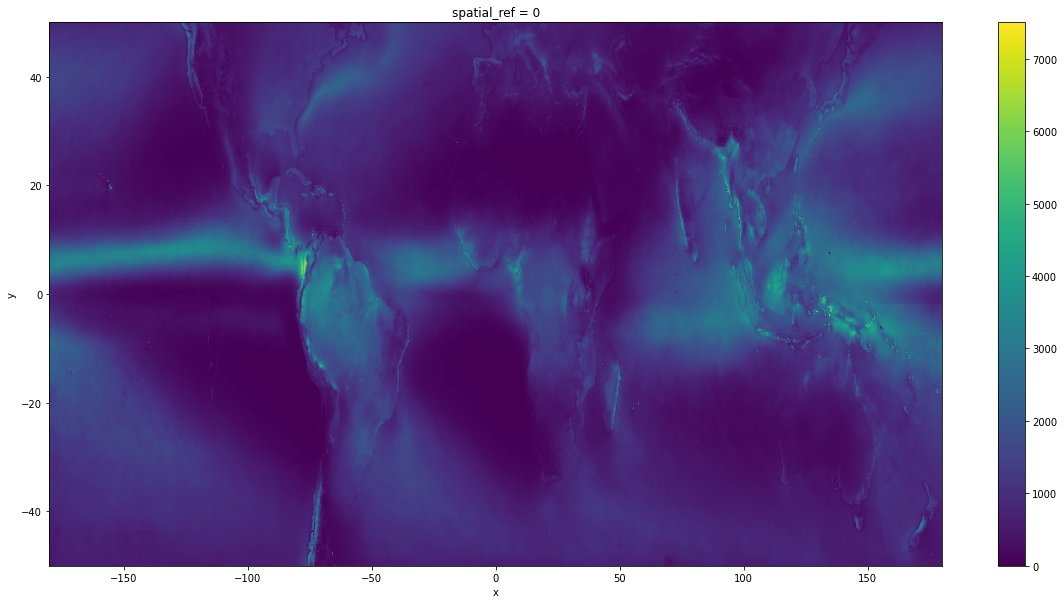

In [6]:
kk.plot(figsize=(20,10), vmin=0)

In [7]:
kk.to_netcdf('chpclim_50n_50s_12month_sum.nc')

Note the NetCDF does not have any inherently associated CRS or geobox properties. We will assign those in the next step, reprojection.

## Reproject CHPclim

In [8]:
dc = datacube.Datacube(app='reprojection')

# Define area of interest
lat = -2.5
lon = 16
lon_buffer = 42
lat_buffer = 45

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

In [9]:
display_map(y=(lat-lat_buffer, lat+lat_buffer),x=(lon-lon_buffer, lon+lon_buffer))

In [10]:
chirps=assign_crs(xr.open_dataarray('./chpclim_50n_50s_12month_sum.nc'),  crs='epsg:4326')
chirps

<xarray.DataArray (y: 2000, x: 7200)>
[14400000 values with dtype=float32]
Coordinates:
  * y            (y) float64 49.97 49.92 49.87 49.82 ... -49.88 -49.93 -49.98
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    spatial_ref  int32 4326
Attributes:
    grid_mapping:  spatial_ref

We can use `rainfall_chirps_monthly` to provide a `geobox` object to project the CHPclim data to.

In [11]:
ds = dc.load(product=['rainfall_chirps_monthly'],
                         time= '2020-01',
                         measurements = ['rainfall'],
                         resolution = (-5000, 5000), # native CHIRPS resolution
                         output_crs = 'EPSG:6933')

In [12]:
# Remove NaNs from chirps_monthly dataset
ds = ds.where(ds !=-9999.)

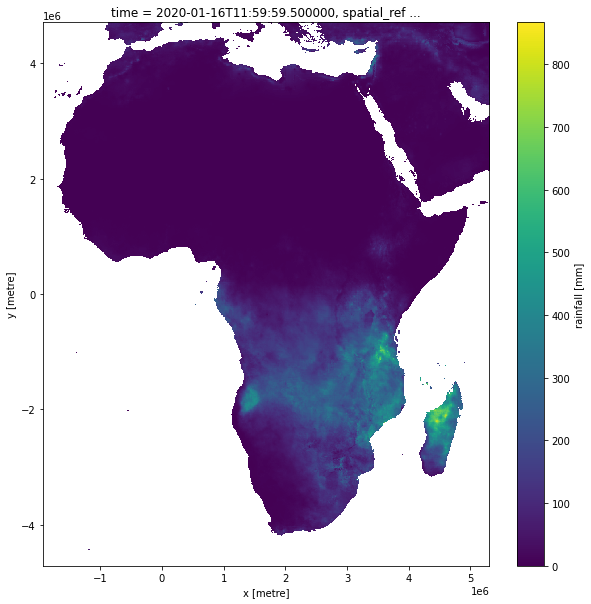

In [13]:
# This is the climatology rainfall for January 
ds.isel(time=0).rainfall.plot.imshow(figsize=(10,10))

In [14]:
chirps_reproject = xr_reproject(chirps,
                         ds.geobox)

chirps_reproject = assign_crs(chirps_reproject, crs=ds.geobox.crs)

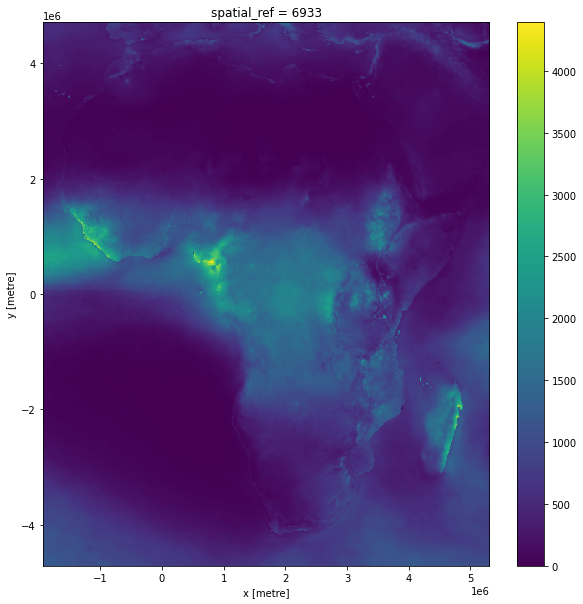

In [16]:
# This is the climatology for the whole year
chirps_reproject.plot.imshow(figsize=(10,10))

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

**Compatible datacube version:**

In [17]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [18]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-01-18'